In [1]:
# Standard library imports
import os
import json
import tempfile
import multiprocessing as mp
import logging
import time
from functools import partial

# Third-party imports
import numpy as np
import pandas as pd
from tqdm import tqdm
import wandb
import jax
import jax.numpy as jnp
from jax import random as jr
from torch.utils.data import DataLoader
import optax
import equinox as eqx

# Foundational SSM imports
from omegaconf import OmegaConf
from foundational_ssm.constants import (
    DATA_ROOT,
    DATASET_IDX_TO_GROUP_SHORT,
)
from foundational_ssm.loaders import get_brainset_train_val_loaders
from foundational_ssm.utils import load_model_and_state_wandb, save_checkpoint_wandb, transfer_foundational_to_downstream, load_checkpoint_wandb
from foundational_ssm.metrics import compute_r2_standard
from foundational_ssm.utils.training import (
    mse_loss_downstream,
    get_filter_spec,
)
from foundational_ssm.samplers import SequentialFixedWindowSampler
from foundational_ssm.collate import pad_collate
from foundational_ssm.models import SSMFoundationalDecoder, SSMDownstreamDecoder


%load_ext autoreload
%autoreload 2

In [2]:
def compute_trial_predictions_r2(val_loader, model, state):
    all_preds = []
    all_targets = []
    all_dataset_group_idxs = []
    for batch in val_loader:
        batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
        dataset_group_idxs = batch["dataset_group_idx"]
        inputs = batch["neural_input"]
        targets = batch["behavior_input"]
        mask = batch["mask"]
        mask = mask[..., None]
        preds, state = jax.vmap(model, axis_name="batch", in_axes=(0, None, 0, None, None), out_axes=(0, None))(inputs, state, dataset_group_idxs, jr.PRNGKey(0), True)

        all_preds.append(jnp.where(mask, preds, 0))
        all_targets.append(jnp.where(mask, targets, 0))
        all_dataset_group_idxs.append(dataset_group_idxs)
        
        
    all_preds = jnp.concatenate(all_preds, axis=0)
    all_targets = jnp.concatenate(all_targets, axis=0)
    all_dataset_group_idxs = jnp.concatenate(all_dataset_group_idxs, axis=0)

    ss_res = jnp.sum((all_targets - all_preds) ** 2, axis=1)
    ss_tot = jnp.sum((all_targets - jnp.mean(all_targets, axis=1)) ** 2, axis=1)
    r2_per_dim = 1 - ss_res / (ss_tot + 1e-8)  # Add epsilon for stability

    all_r2 = jnp.mean(r2_per_dim, axis=1)

    return all_preds, all_targets, all_dataset_group_idxs, all_r2

def add_best_alias_to_checkpoint(checkpoint_artifact, metadata):
    checkpoint_artifact.wait()
    if 'best' not in checkpoint_artifact.aliases:
        checkpoint_artifact.aliases.append('best')
    checkpoint_artifact.metadata.update(metadata)
    checkpoint_artifact.save()
    

In [3]:
config_path = "/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/configs/pretrain.yaml"
cfg = OmegaConf.load(config_path) 
api = wandb.Api()
logging.basicConfig(filename='pretrain_decoding.log', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)
best_r2_score = 0

train_dataset, train_loader, val_dataset, val_loader = get_brainset_train_val_loaders(
        cfg.train_loader,
        cfg.val_loader,
        data_root='../'+DATA_ROOT,
    )

key, train_key, val_key = jr.split(jr.PRNGKey(cfg.rng_seed), 3)
model = SSMFoundationalDecoder(
        **cfg.model
    )
state = eqx.nn.State(model)
filter_spec = get_filter_spec(
    model,
    **cfg.filter_spec
)
lr_scheduler = lambda step: cfg.optimizer.lr
opt = optax.chain(
    optax.adamw(learning_rate=lr_scheduler, weight_decay=cfg.optimizer.weight_decay)
)
opt_state = opt.init(eqx.filter(model, filter_spec))

INFO:2025-08-04 13:54:58,626:jax._src.xla_bridge:830: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [5]:
model, state, opt_state, last_epoch, current_step, checkpoint_metadata = load_checkpoint_wandb(
            path=None,  # path is ignored, wandb is used
            model_template=model,
            state_template=state,
            opt_state_template=opt_state,
            filter_spec=filter_spec,
            wandb_run_name='inverse_variance_l2_d128',
            wandb_project=cfg.wandb.project,
            wandb_entity=cfg.wandb.entity,
            wandb_alias='best'
        )

wandb:   1 of 1 files downloaded.  


Loading checkpoint from: /tmp/tmpyiwcpv3b/tmp5v21z_n6.ckpt


In [6]:
all_preds = []
all_targets = []
all_dataset_group_idxs = []
for batch in tqdm(val_loader):
    batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
    dataset_group_idxs = batch["dataset_group_idx"]
    inputs = batch["neural_input"]
    targets = batch["behavior_input"]
    mask = batch["mask"]
    mask = mask[..., None]
    preds, state = jax.vmap(model, axis_name="batch", in_axes=(0, None, 0, None, None), out_axes=(0, None))(inputs, state, dataset_group_idxs, jr.PRNGKey(0), True)

    all_preds.append(jnp.where(mask, preds, 0))
    all_targets.append(jnp.where(mask, targets, 0))
    all_dataset_group_idxs.append(dataset_group_idxs)
    
all_preds = jnp.concatenate(all_preds, axis=0)
all_targets = jnp.concatenate(all_targets, axis=0)
all_dataset_group_idxs = jnp.concatenate(all_dataset_group_idxs, axis=0)

ss_res = jnp.sum((all_targets - all_preds) ** 2, axis=1)
ss_tot = jnp.sum((all_targets - jnp.mean(all_targets, axis=1, keepdims=True)) ** 2, axis=1)
r2_per_dim = 1 - ss_res / (ss_tot + 1e-8)  # Add epsilon for stability

all_r2 = jnp.mean(r2_per_dim, axis=1)

  0%|          | 0/11 [00:00<?, ?it/s]/tmp/ipykernel_2144113/56028895.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
 27%|██▋       | 3/11 [00:27<01:05,  8.25s/it]/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/scipy/interpolate/_interpolate.py:479: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
100%|██████████| 11/11 [02:45<00:00, 15.04s/it]


array([[<Axes: title={'center': 'cs_j_co'}>,
        <Axes: title={'center': 'cs_n_co'}>,
        <Axes: title={'center': 'os_i_rt'}>],
       [<Axes: title={'center': 'os_l_rt'}>,
        <Axes: title={'center': 'pm_c_co'}>,
        <Axes: title={'center': 'pm_c_rt'}>],
       [<Axes: title={'center': 'pm_m_co'}>,
        <Axes: title={'center': 'pm_m_rt'}>,
        <Axes: title={'center': 'pp_j_mz'}>]], dtype=object)

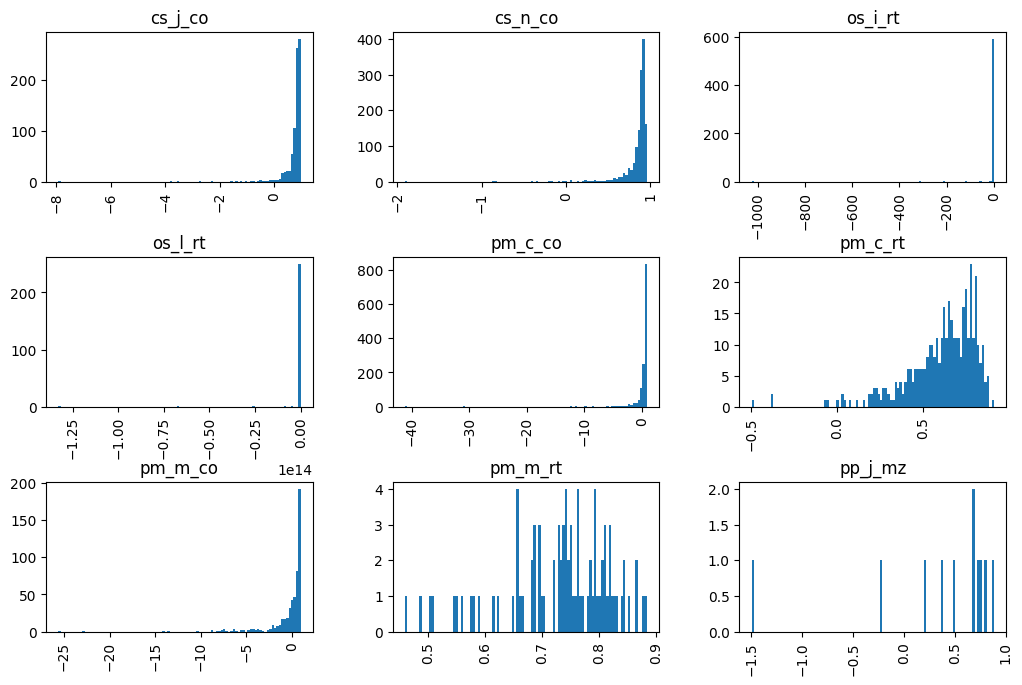

In [ ]:
r2_df = pd.DataFrame({'dataset_group_idx': all_dataset_group_idxs, 'r2': all_r2, 'idx': np.arange(len(all_r2))})
r2_df['dataset_group'] = r2_df['dataset_group_idx'].map(DATASET_IDX_TO_GROUP_SHORT)

#get rank by desceding r2 per group 
r2_df.hist(column='r2', by='dataset_group', figsize=(12, 8), bins=100)


In [50]:
# format as 2 d.p. not scientific notation
r2_df['r2_min_0'] = r2_df['r2'].apply(lambda x: 0 if x < 0 else x)
r2_df.groupby('dataset_group').agg({'r2_min_0': ['mean', 'std', 'count']}).reset_index().rename(columns={'mean': 'mean_r2', 'std': 'std_r2', 'count': 'count_r2'}).applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x)

/tmp/ipykernel_2144113/2739570042.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  r2_df.groupby('dataset_group').agg({'r2_min_0': ['mean', 'std', 'count']}).reset_index().rename(columns={'mean': 'mean_r2', 'std': 'std_r2', 'count': 'count_r2'}).applymap(lambda x: f"{x:.2f}" if isinstance(x, float) else x)


dataset_group r2_min_0                
                 mean_r2 std_r2 count_r2
0       cs_j_co     0.76   0.22      815
1       cs_n_co     0.85   0.14     1379
2       os_i_rt     0.53   0.23      599
3       os_l_rt     0.33   0.27      255
4       pm_c_co     0.57   0.33     1333
5       pm_c_rt     0.61   0.19      400
6       pm_m_co     0.41   0.36      523
7       pm_m_rt     0.73   0.09       86
8       pp_j_mz     0.51   0.32       11

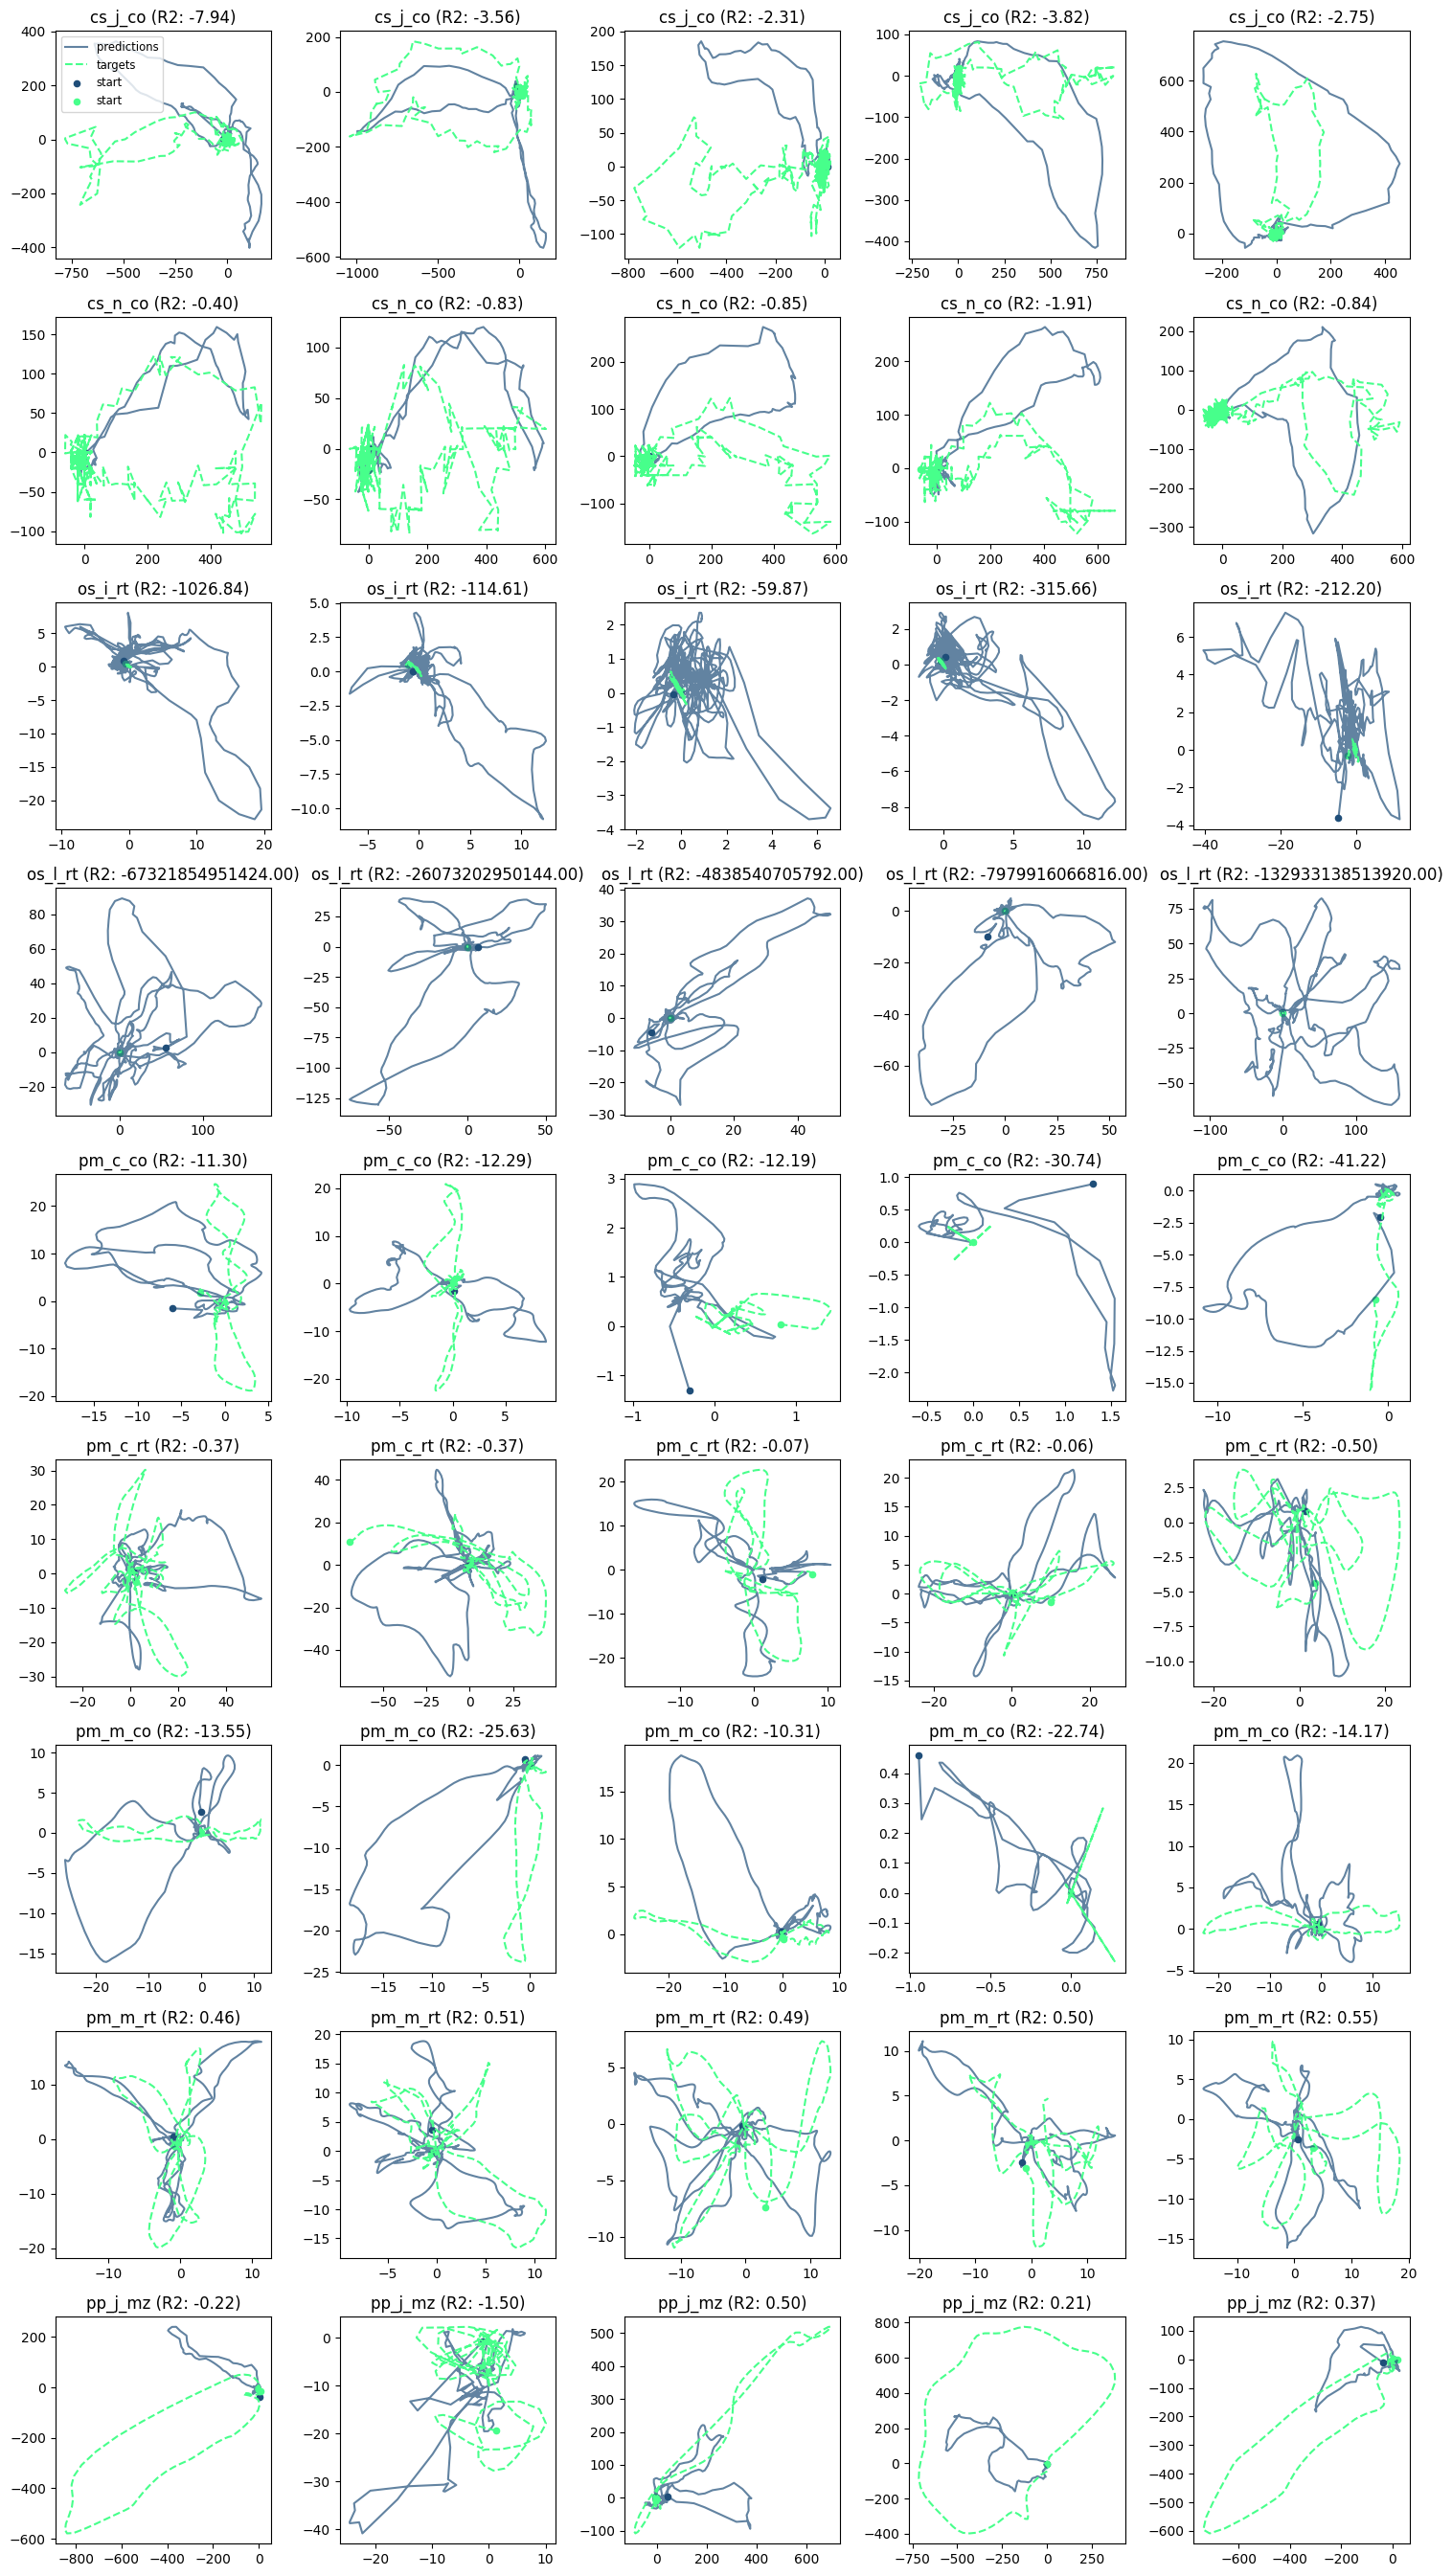

In [51]:
import matplotlib.pyplot as plt
r2_df_pos = r2_df
r2_df_pos['rank'] = r2_df_pos.groupby('dataset_group')['r2'].rank(ascending=True, method='first')
df_to_plot = r2_df_pos[(r2_df_pos['rank'] <= 5)].sort_values('dataset_group', ascending=True).reset_index(drop=True)
fig, axs = plt.subplots(9, 5, figsize=(15, 27))
axs = axs.flatten() 



colors = {
    'target': "#47FF8B",    # Light blue (before)
    'prediction': '#1F4E79'   # Dark blue (after)
}

for i, row in df_to_plot.iterrows():
    group = row['dataset_group']
    idx = row['idx']
    r2 = row['r2']
    preds = all_preds[idx]
    targets = all_targets[idx] 
    ax = axs[i]
    axs[i].plot(all_preds[idx,:,0], all_preds[idx,:,1], label='predictions', color=colors['prediction'], alpha=0.7)
    axs[i].plot(all_targets[idx,:,0], all_targets[idx,:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(all_preds[idx,0,0], all_preds[idx,0,1], color=colors['prediction'], s=20, label='start')
    axs[i].scatter(all_targets[idx,0,0], all_targets[idx,0,1], color=colors['target'], s=20, label='start')
    axs[i].set_title(f"{group} (R2: {r2:.2f})")
    
    
axs[0].legend(loc='upper left', fontsize='small')
plt.tight_layout()

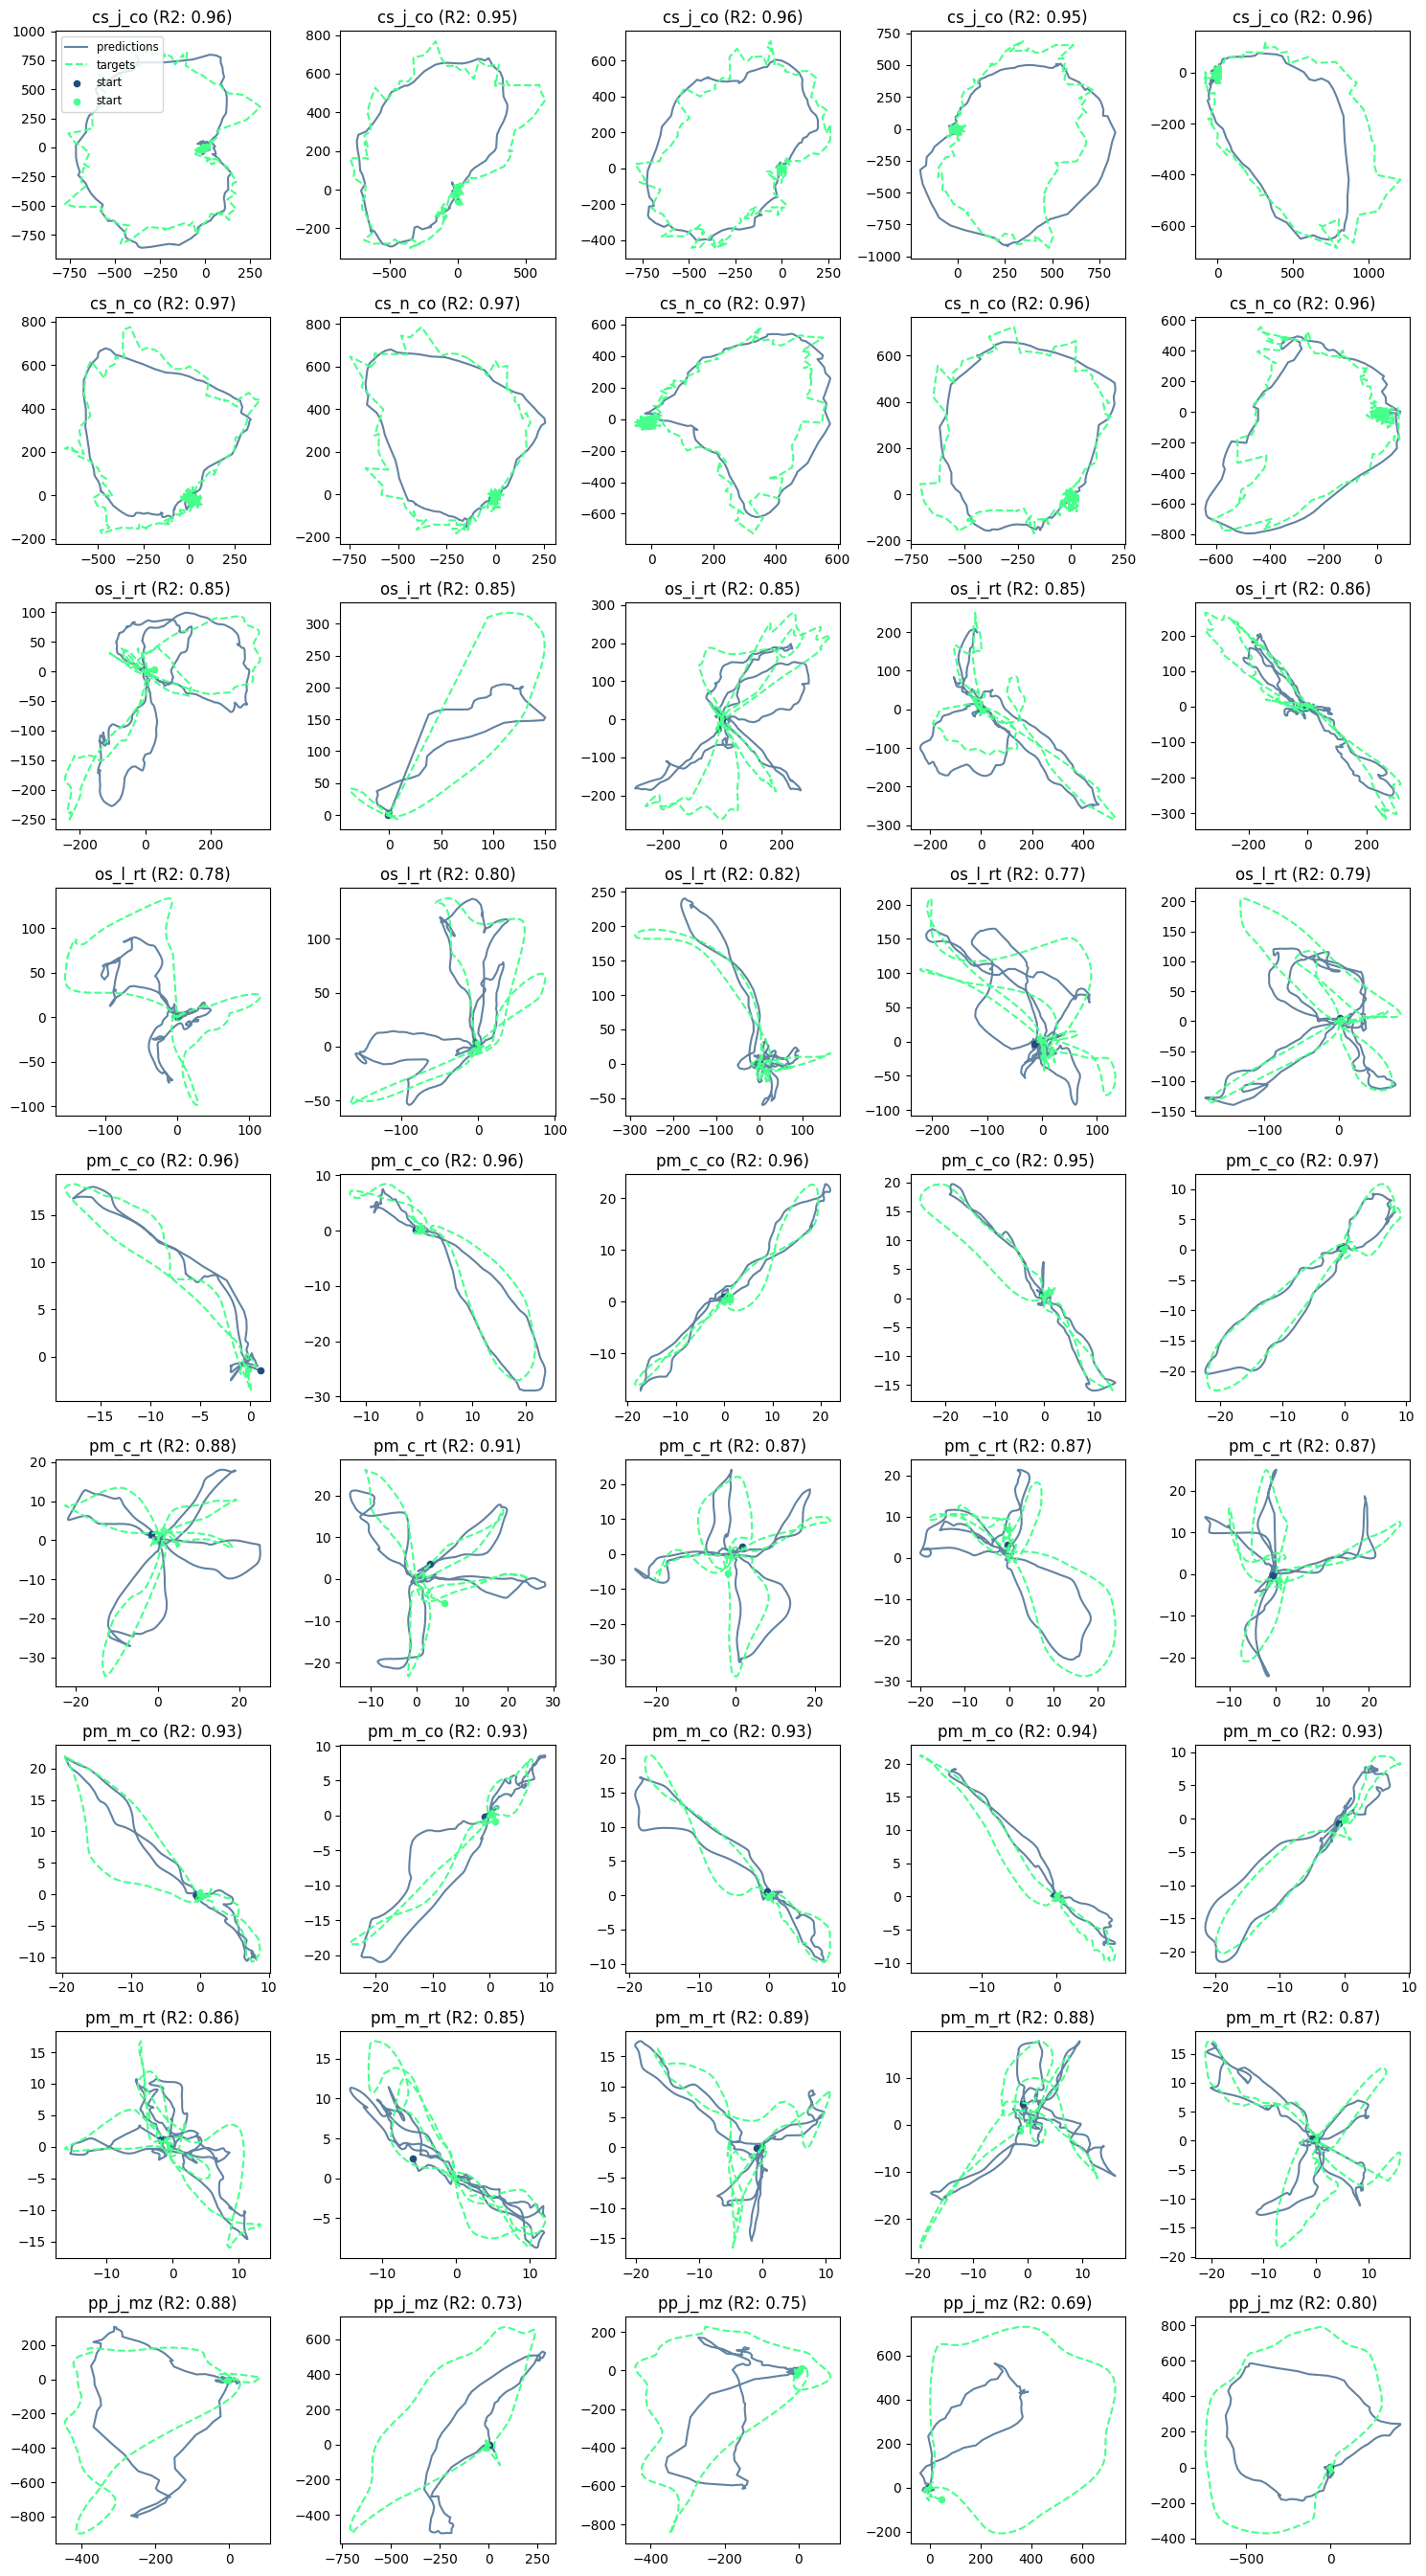

In [38]:
import matplotlib.pyplot as plt
r2_df['rank'] = r2_df.groupby('dataset_group')['r2'].rank(ascending=False, method='first')
df_to_plot = r2_df[r2_df['rank'] <= 5].sort_values('dataset_group', ascending=True).reset_index(drop=True)
fig, axs = plt.subplots(9, 5, figsize=(15, 27))
axs = axs.flatten() 



colors = {
    'target': "#47FF8B",    # Light blue (before)
    'prediction': '#1F4E79'   # Dark blue (after)
}

for i, row in df_to_plot.iterrows():
    group = row['dataset_group']
    idx = row['idx']
    r2 = row['r2']
    preds = all_preds[idx]
    targets = all_targets[idx] 
    ax = axs[i]
    axs[i].plot(all_preds[idx,:,0], all_preds[idx,:,1], label='predictions', color=colors['prediction'], alpha=0.7)
    axs[i].plot(all_targets[idx,:,0], all_targets[idx,:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(all_preds[idx,0,0], all_preds[idx,0,1], color=colors['prediction'], s=20, label='start')
    axs[i].scatter(all_targets[idx,0,0], all_targets[idx,0,1], color=colors['target'], s=20, label='start')
    axs[i].set_title(f"{group} (R2: {r2:.2f})")

axs[0].legend(loc='upper left', fontsize='small')
plt.tight_layout()

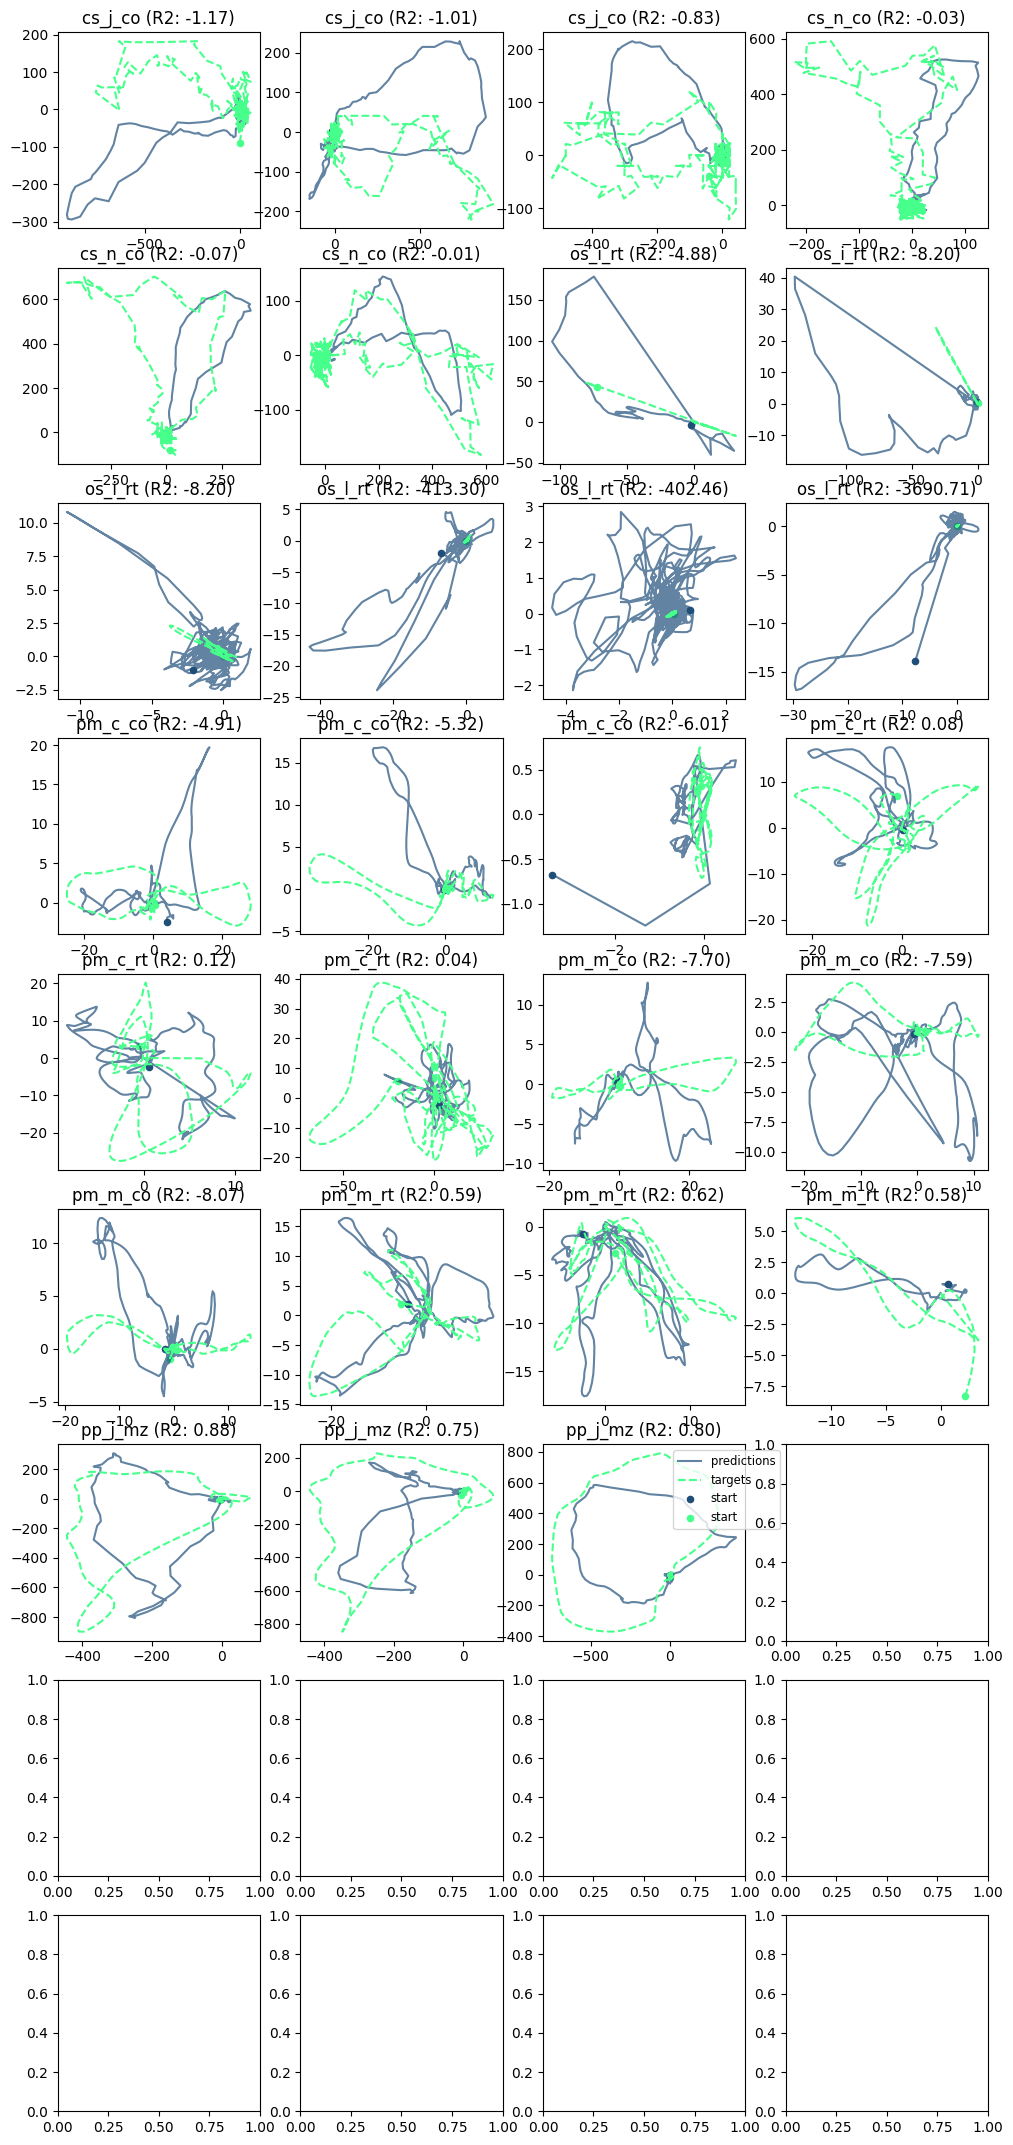

In [30]:
import matplotlib.pyplot as plt
r2_df['rank'] = r2_df.groupby('dataset_group')['r2'].rank(ascending=True, method='first')
df_to_plot = r2_df[(r2_df['rank'] >8) &  (r2_df['rank'] <12)].sort_values('dataset_group', ascending=True).reset_index(drop=True)
fig, axs = plt.subplots(9, 4, figsize=(12, 27))
axs = axs.flatten() 



colors = {
    'target': "#47FF8B",    # Light blue (before)
    'prediction': '#1F4E79'   # Dark blue (after)
}

for i, row in df_to_plot.iterrows():
    group = row['dataset_group']
    idx = row['idx']
    r2 = row['r2']
    preds = all_preds[idx]
    targets = all_targets[idx] 
    ax = axs[i]
    axs[i].plot(all_preds[idx,:,0], all_preds[idx,:,1], label='predictions', color=colors['prediction'], alpha=0.7)
    axs[i].plot(all_targets[idx,:,0], all_targets[idx,:,1], label='targets', color=colors['target'], linestyle='--')
    axs[i].scatter(all_preds[idx,0,0], all_preds[idx,0,1], color=colors['prediction'], s=20, label='start')
    axs[i].scatter(all_targets[idx,0,0], all_targets[idx,0,1], color=colors['target'], s=20, label='start')
    axs[i].set_title(f"{group} (R2: {r2:.2f})")
    
    
axs[i].legend(loc='upper right', bbox_to_anchor=(1.2, 1), fontsize='small')

In [8]:
metrics = {} 
unique_dataset_group_idxs = jnp.unique(all_dataset_group_idxs)
for dataset_group_idx in unique_dataset_group_idxs:
    dataset_group_idx = int(dataset_group_idx)
    dataset_group_short_name = DATASET_IDX_TO_GROUP_SHORT[dataset_group_idx]
    dataset_group_mask = all_dataset_group_idxs == dataset_group_idx
    preds = all_preds[dataset_group_mask]
    targets = all_targets[dataset_group_mask]
    r2_score = compute_r2_standard(preds, targets)
    metrics[f"val/r2_{dataset_group_short_name}"] = float(r2_score)

r2_score = compute_r2_standard(all_preds, all_targets)
metrics['val/r2_avg'] = float(np.mean([metrics[key] for key in metrics.keys() if "r2" in key]))
metrics['val/r2_all'] = float(r2_score)

In [9]:
metrics

{'val/r2_pm_c_co': 0.7762905359268188,
 'val/r2_pm_c_rt': 0.6353428363800049,
 'val/r2_pm_m_rt': 0.7789604663848877,
 'val/r2_pm_m_co': 0.7145344018936157,
 'val/r2_pp_j_mz': 0.6100215315818787,
 'val/r2_os_i_rt': 0.6560381650924683,
 'val/r2_os_l_rt': 0.5938899517059326,
 'val/r2_cs_j_co': 0.8495067358016968,
 'val/r2_cs_n_co': 0.9059766530990601,
 'val/r2_avg': 0.7245068086518182,
 'val/r2_all': 0.854983389377594}

In [ ]:
config_path = "/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/configs/pretrain.yaml"
cfg = OmegaConf.load(config_path) 
api = wandb.Api()
logging.basicConfig(filename='pretrain_decoding.log', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)
tempdir = "/cs/student/projects1/ml/2024/mlaimon/foundational_ssm/wandb_artifacts"
best_r2_score = 0

key, train_key, val_key = jr.split(jr.PRNGKey(cfg.rng_seed), 3)

for dataset_name, config in cfg.downstream_datasets.items():
    cfg.train_loader.dataset_args.update({'config':config})
    cfg.val_loader.dataset_args.update({'config':config})
    train_dataset, train_loader, val_dataset, val_loader = get_brainset_train_val_loaders(
        cfg.train_loader,
        cfg.val_loader,
        data_root = '../' + DATA_ROOT
    )

    for name, artifact_full_name in cfg.models.items():
        # ===========================================================
        # load_checkpoint 
        # ===========================================================
        artifact = api.artifact(artifact_full_name, type="checkpoint")
        foundational_run = artifact.logged_by()
        foundational_run_cfg = OmegaConf.create(foundational_run.config)
        
        foundational_model = SSMFoundationalDecoder(
                **foundational_run_cfg.model
            )
        
        downstream_model_cfg = foundational_run_cfg.model.copy()
        downstream_model_cfg.update({'input_dim':625})
        downstream_model = SSMDownstreamDecoder(**downstream_model_cfg)
        

        

        # Create temporary directory for download
        with tempfile.TemporaryDirectory() as temp_dir:
            artifact.download(temp_dir)
            
            # Find the checkpoint file in the downloaded directory
            checkpoint_files = [f for f in os.listdir(temp_dir) if f.endswith('.ckpt')]
            if not checkpoint_files:
                print(f"Available files in {temp_dir}: {os.listdir(temp_dir)}")
                raise FileNotFoundError(f"No checkpoint file found in {temp_dir}. Available files: {os.listdir(temp_dir)}")
            
            checkpoint_path = os.path.join(temp_dir, checkpoint_files[0])
            print(f"Loading checkpoint from: {checkpoint_path}")
            
            with open(checkpoint_path, 'rb') as f:
                meta = json.loads(f.readline().decode())
                foundational_model = eqx.tree_deserialise_leaves(f, foundational_model)
                # state = eqx.tree_deserialise_leaves(f, state)
                # opt_state = eqx.tree_deserialise_leaves(f, opt_state)
                
        # ===================================================================================
        #  Define downstream model based on foundational model architecture and input dim
        # ===================================================================================
        
        downstream_model = transfer_foundational_to_downstream(foundational_model, downstream_model)
        downstream_state = eqx.nn.State(downstream_model)
        
        run_name = f"{dataset_name}_l{downstream_model_cfg.ssm_num_layers}_d{downstream_model_cfg.ssm_dim}"
        # wandb.init(project=cfg.wandb.project, name=run_name, config=dict(cfg)) 
        
        filter_spec = get_filter_spec(
            downstream_model,
            **cfg.filter_spec
        )
        
        lr_scheduler = lambda step: cfg.optimizer.lr
        
        opt = optax.chain(
            optax.adamw(learning_rate=lr_scheduler, weight_decay=cfg.optimizer.weight_decay)
        )
        opt_state = opt.init(eqx.filter(downstream_model, filter_spec))
        
        current_step = 0
    


INFO:2025-07-27 23:20:19,886:jax._src.xla_bridge:830: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
wandb:   1 of 1 files downloaded.  


Loading checkpoint from: /tmp/tmps9d7erdt/tmpygg3xt4i.ckpt


wandb: Currently logged in as: melinajingting (melinajingting-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/multiprocessing/popen_fork.py:67: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


36
512
512
512
512
512
512


/tmp/ipykernel_2965850/3891174369.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
/cs/student/projects1/ml/2024/mlaimon/anaconda3/envs/foundational_ssm/lib/python3.13/site-packages/jax/_src/lax/lax.py:5371: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


No previous checkpoint to delete or deletion failed: 404 Client Error: Not Found for url: https://api.wandb.ai/graphql
Saved checkpoint at epoch 0
63


/tmp/ipykernel_2965850/3891174369.py:51: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}


36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512512

512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512512512512512




512
36
512
512
512
512
512
512
36
512
512
512512

512
512
36
512
512
512
512
512512

36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512512

512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512512

512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512512

512512

36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512512

512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
3

ArtifactNotLoggedError: 'Artifact.aliases' used prior to logging artifact or while in offline mode. Call Artifact.wait() before accessing logged artifact properties.

36
512
512
512
512
512
512
63
36
512
512
512
512
512
512
36
512
512512

512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512512

36
512512

512
512
512
512
36
512
512
512512

512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512512

512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512512

512
512
512
36
512
512
512
512
512
512
36
512
512
512512

512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512512

512
512
512
36
512
512
512
512
512512

36
512
512
512
512
512
512
36
512512

512
512
512
512
36
512512

512
512
512
512
36
512512512


512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512512

36
512
512
512512512


512
36
512
512
512
512512

512
36
512
512
512
512
512
512
36
512
512
512
512
512
512
36
512512

512
512
512
512
36
512
512
512
512
512
512
36
512
512
512
512
512
51

In [ ]:
for epoch in range(1, cfg.training.epochs + 1):
    train_key, subkey = jr.split(train_key)
    logger.info(f"Running training for epoch {epoch}")
    downstream_model, downstream_state, opt_state, current_step, epoch_loss = train_one_epoch(train_loader, downstream_model, downstream_state, subkey, filter_spec, mse_loss_downstream, opt, opt_state, lr_scheduler, current_step, epoch)

    if epoch % cfg.training.checkpoint_every == 0:
        metadata = {
            'train_loss': epoch_loss
        }
        logger.info(f"Saving checkpoint for epoch {epoch}")
        checkpoint_artifact = save_checkpoint_wandb(downstream_model, downstream_state, opt_state, epoch, current_step, metadata, run_name)

    if epoch % cfg.training.log_val_every == 0:
        logger.info(f"Running validation for epoch {epoch}")
        metrics = validate_one_epoch(val_loader, downstream_model, downstream_state, epoch, current_step, dataset_name)
        
        # Track best R² score
        current_r2_avg = metrics.get(f'val/r2_{dataset_name}', 0.0)
        if current_r2_avg > best_r2_score:
            best_r2_score = current_r2_avg
            logger.info(f"New best R² score: {best_r2_score:.4f} at epoch {epoch}")
            add_best_alias_to_checkpoint(checkpoint_artifact, metrics)

/tmp/ipykernel_2965850/1288703338.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}


Saved checkpoint at epoch 1000


/tmp/ipykernel_2965850/1288703338.py:51: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}


Saved checkpoint at epoch 1050
Saved checkpoint at epoch 1100
Saved checkpoint at epoch 1150
Saved checkpoint at epoch 1200
Saved checkpoint at epoch 1250
Saved checkpoint at epoch 1300
Saved checkpoint at epoch 1350
Saved checkpoint at epoch 1400
Saved checkpoint at epoch 1450


In [6]:
current_r2_avg = metrics.get(f'val/r2_{dataset_name}', 0.0)
if current_r2_avg > best_r2_score:
    best_r2_score = current_r2_avg
    logger.info(f"New best R² score: {best_r2_score:.4f} at epoch {epoch}")
    add_best_alias_to_checkpoint(checkpoint_artifact, metrics)

In [7]:
metrics.get(f'val/r2_{dataset_name}', 0.0)

-0.02722528576850891

In [63]:
train_dataset.get_recording_data('perich_miller_population_2018/t_20130820_random_target_reaching').slice(1,2).cursor.vel

array([[-4.52259966e+00, -4.40530186e+00],
       [-3.98662263e+00, -4.07797472e+00],
       [-3.63468363e+00, -3.59428768e+00],
       [-3.53308979e+00, -2.95021576e+00],
       [-3.35347289e+00, -2.40125816e+00],
       [-2.83800323e+00, -2.07358337e+00],
       [-2.17900784e+00, -1.75543655e+00],
       [-1.71787771e+00, -1.22573236e+00],
       [-1.45726466e+00, -6.32869245e-01],
       [-1.14002561e+00, -2.99200331e-01],
       [-7.09769236e-01, -2.19816364e-01],
       [-3.95300375e-01, -7.21099813e-02],
       [-3.04495933e-01,  2.13249340e-01],
       [-2.15810761e-01,  2.73179841e-01],
       [ 4.79653719e-02, -5.47544683e-02],
       [ 2.72149387e-01, -3.30768028e-01],
       [ 1.55045999e-01, -1.44365528e-01],
       [-2.03970414e-01,  2.18576692e-01],
       [-4.29177133e-01,  2.13434609e-01],
       [-3.94584050e-01, -1.44429852e-01],
       [-3.35921779e-01, -3.81517424e-01],
       [-4.46477065e-01, -2.88154475e-01],
       [-6.21500456e-01, -8.35304384e-02],
       [-6.

In [ ]:


train_dataset, train_loader, val_dataset, val_loader = get_brainset_train_val_loaders(
    cfg.train_loader,
    cfg.val_loader,
    data_root='../'+DATA_ROOT
)
model_artifact_id = ''
model, state = load_model_and_state_wandb(model_artifact_id)
key, train_key, val_key = jr.split(jr.PRNGKey(cfg.rng_seed), 3)

train_sampling_intervals = train_dataset.get_sampling_intervals()
val_sampling_intervals = val_dataset.get_sampling_intervals()

mp.set_start_method("spawn", force=True)
window_length = 1
sampling_rate = 200

recording_metrics_list = []

wandb:   1 of 1 files downloaded.  


In [47]:
def validate_one_epoch(val_loader, model, state):
    metrics = {}  # New: store metrics per group
    all_preds = []
    all_targets = []
    all_dataset_group_idxs = []
    all_masks = []
    for batch_idx, batch in enumerate(val_loader):
        batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
        dataset_group_idxs = batch["dataset_group_idx"]
        inputs = batch["neural_input"]
        targets = batch["behavior_input"]
        mask = batch["mask"]
        all_masks.append(mask)
        mask = mask[..., None]
        # random key is supposed to be used for dropout, but is just a placeholder when in inference mode
        preds, state = jax.vmap(model, axis_name="batch", in_axes=(0, None, None, 0, None), out_axes=(0, None))(inputs, state, jr.PRNGKey(0), dataset_group_idxs, True)

        all_preds.append(jnp.where(mask, preds, 0))
        all_targets.append(jnp.where(mask, targets, 0))
        all_dataset_group_idxs.append(dataset_group_idxs)
        


    all_preds = jnp.concatenate(all_preds, axis=0)
    all_targets = jnp.concatenate(all_targets, axis=0)
    all_dataset_group_idxs = jnp.concatenate(all_dataset_group_idxs, axis=0)
    unique_dataset_group_idxs = jnp.unique(all_dataset_group_idxs)
    for dataset_group_idx in unique_dataset_group_idxs:
        dataset_group_idx = int(dataset_group_idx)
        dataset_group_short_name = DATASET_IDX_TO_GROUP_SHORT[dataset_group_idx]
        dataset_group_mask = all_dataset_group_idxs == dataset_group_idx
        preds = all_preds[dataset_group_mask]
        targets = all_targets[dataset_group_mask]
        r2_score = compute_r2_standard(preds, targets)
        metrics[f"val/r2_{dataset_group_short_name}"] = float(r2_score)
    
    r2_score = compute_r2_standard(all_preds, all_targets)
    metrics['val/r2_avg'] = float(np.mean([metrics[key] for key in metrics.keys() if "r2" in key]))
    metrics['val/r2_all'] = float(r2_score)

    return metrics, all_preds, all_targets, all_dataset_group_idxs, all_masks

def compute_variance_mse_r2(preds, targets):
    preds = preds.reshape(-1, preds.shape[-1])
    targets = targets.reshape(-1, targets.shape[-1]) 
    
    mse = jnp.mean((targets - preds) ** 2)         # Per-dimension MSE
    var = jnp.var(targets) 
    
    ss_res = jnp.sum((targets - preds) ** 2, axis=0) 
    ss_tot = jnp.sum((targets - jnp.mean(targets, axis=0)) ** 2, axis=0)
    r2_per_dim = 1 - ss_res / (ss_tot + 1e-8) # Add epsilon for stability
    return var, mse, jnp.mean(r2_per_dim)

def compute_interval_metrics(recording_data, sampling_intervals, model, state, window_length, sampling_rate, prefix='', rng_key = jr.PRNGKey(0)):
    #deterministic random key for the dropout. TODO: expose inference variable in S5Block all the way up to SSMFoundationalDecoder
    metrics = {}
    interval = list(sampling_intervals.values())[0]
    metrics[f'{prefix}total_duration'] = np.sum(interval.end - interval.start)
    metrics[f'{prefix}mean_duration']  = np.mean(interval.end - interval.start)
    try:
        sampler = SequentialFixedWindowSampler(sampling_intervals=sampling_intervals, window_length=window_length, drop_short=True)
        loader = DataLoader(
            dataset=recording_data,
            sampler=sampler,
            batch_size=256,
            collate_fn=partial(pad_collate, fixed_seq_len=int(window_length*sampling_rate)),
            num_workers=4,
            pin_memory=True,
            persistent_workers=False
        )
        all_preds = []
        all_targets = []
        all_mask = []
        for batch in loader:
            batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}
            inputs, targets, mask, dataset_group_idxs = batch.values()
            all_mask.append(mask)
            mask = mask[..., None]
            preds, state = jax.vmap(model, axis_name="batch", in_axes=(0, None, None, 0), out_axes=(0, None))(inputs, state, rng_key, dataset_group_idxs)
            
            all_preds.append(jnp.where(mask, preds, 0))
            all_targets.append(jnp.where(mask, targets, 0))
            
        all_preds = jnp.concatenate(all_preds, axis=0)
        all_targets = jnp.concatenate(all_targets, axis=0)
        var, mse, r2 = compute_variance_mse_r2(preds, targets)
    except:
        var, mse, r2 = np.nan, np.nan, np.nan 
    metrics.update({
        f'{prefix}var': var,
        f'{prefix}mse': mse,
        f'{prefix}r2': r2,
    }) 
    return metrics
    

In [45]:
from foundational_ssm.utils.wandb_utils_jax import save_checkpoint_wandb, load_checkpoint_wandb
from foundational_ssm.utils.training import get_filter_spec
import optax
import equinox as eqx

lr_scheduler = lambda step: cfg.optimizer.lr
filter_spec = get_filter_spec(
        model,
        **cfg.filter_spec
    )
opt = optax.chain(
    optax.adamw(learning_rate=lr_scheduler, weight_decay=cfg.optimizer.weight_decay)
)
opt_state = opt.init(eqx.filter(model, filter_spec))
run_name = f"possm_dataset_l1_d128"
model, state, opt_state, last_epoch, current_step, checkpoint_metadata = load_checkpoint_wandb(
            path=None,  # path is ignored, wandb is used
            model_template=model,
            state_template=state,
            opt_state_template=opt_state,
            wandb_run_name=run_name,
            wandb_project=cfg.wandb.project,
            wandb_entity=cfg.wandb.entity,
        )

wandb:   1 of 1 files downloaded.  


Loading checkpoint from: /tmp/tmpai847_7_/tmp51zco2v2.ckpt


In [48]:
metrics, all_preds, all_targets, all_dataset_group_idxs, all_masks = validate_one_epoch(val_loader, model, state)

/tmp/ipykernel_1354200/2479871795.py:8: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  batch = {k: jax.device_put(np.array(v)) for k, v in batch.items()}


In [12]:
all_trial_types = []
val_sampling_intervals = val_dataset.get_sampling_intervals()
for session_id, interval in val_sampling_intervals.items():
    val_recording = val_dataset.get_recording_data(session_id)
    val_trials = val_recording.trials.select_by_interval(interval)
    trial_types = val_trials.trial_type
    valid_mask = val_trials.is_valid
    all_trial_types.append(trial_types[valid_mask])
all_trial_types = np.concatenate(all_trial_types)

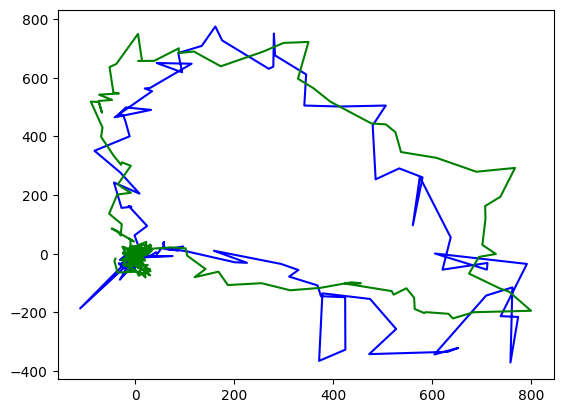

In [27]:
import matplotlib.pyplot as plt
preds_to_plot = all_preds[all_dataset_group_idxs==7]
targets_to_plot = all_targets[all_dataset_group_idxs==7]
masks = all_masks[all_dataset_group_idxs==7]
for i in range(2,3):
    mask = masks[i]
    plt.plot(preds_to_plot[i,mask,0], preds_to_plot[i,mask,1], color='b')
    plt.plot(targets_to_plot[i,mask,0], targets_to_plot[i,mask,1], color='g')
    

In [32]:
# all_masks = np.concatenate(all_masks)
preds_to_plot[i,:,1]

Array([-11.591455, -13.774435, -13.243316, ...,   0.      ,   0.      ,
         0.      ], dtype=float32)

In [24]:
all_masks = all_masks.reshape([-1,1200])